# Project

<https://www.analyticsvidhya.com/blog/2021/12/sentiment-analysis-on-tweets-with-lstm-for-beginners/>

<https://www.kaggle.com/code/stoicstatic/twitter-sentiment-analysis-for-beginners>

## Global Variables

In [1]:
SENTIMENT140_TRAIN = "datasets/training.1600000.processed.noemoticon.csv"
SENTIMENT140_FIELDS = ["target", "ids", "date", "flag", "user", "text"]

## Git LFS

Pull the datasets from Git LFS

In [2]:
!git lfs pull -I "datasets/training.1600000.processed.noemoticon.csv"

## Import, Initialize, & Configure

### Environment Variables

`python-dotenv` is used to load environment variables from the `.env` file.

In [3]:
import os
import dotenv

dotenv.load_dotenv()

True

### numpy

`numpy` is used for numerical processing.

In [4]:
import numpy as np

### Seaborn

`seaborn` is used to set the default style for plots.

In [5]:
import seaborn as sns

### Matplotlib

`matplotlib` is used to plot the data.

In [6]:
import matplotlib.pyplot as plt

### Pandas

`pandas` is a Python library for data manipulation and analysis.

In [7]:
import pandas as pd

pd.set_option("display.max_colwidth", 20)

### Weights & Biases

[Weights & Biases](https://www.wandb.com/) is used for tracking and visualizing experiments.

In [8]:
import wandb

wandb.finish()
wandb.login(key=os.getenv("WANDB_API_KEY"))

wandb: Currently logged in as: jagustin (subsystem3). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/user/.netrc


True

## Exploratory Data Analysis (EDA)

### Sentiment140 Dataset

<http://help.sentiment140.com/for-students>

Sentiment140 is a dataset containing 1.6 million tweets with sentiment labels. 

It allows you to discover the sentiment of a brand, product, or topic on Twitter. 

The data is a CSV with emoticons removed. 

In [9]:
df_train = pd.read_csv(
    SENTIMENT140_TRAIN,
    encoding="ISO-8859-1",
    names=SENTIMENT140_FIELDS,
    header=None,
)

In [10]:
df_train.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19...,NO_QUERY,_TheSpecialOne_,@switchfoot http...
1,0,1467810672,Mon Apr 06 22:19...,NO_QUERY,scotthamilton,is upset that he...
2,0,1467810917,Mon Apr 06 22:19...,NO_QUERY,mattycus,@Kenichan I dive...
3,0,1467811184,Mon Apr 06 22:19...,NO_QUERY,ElleCTF,my whole body fe...
4,0,1467811193,Mon Apr 06 22:19...,NO_QUERY,Karoli,@nationwideclass...


The dataset has 6 fields:

1. `target` — the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
1. `id` — the id of the tweet (2087)
1. `date` — the date of the tweet (Sat May 16 23:58:44 UTC 2009)
1. `flag` — the query (lyx). If there is no query, then this value is NO_QUERY.
1. `user` — the user that tweeted (robotickilldozr)
1. `text` — the text of the tweet (Lyx is cool)

In [11]:
print(f"df_train.shape: {df_train.shape}")

df_train.shape: (1600000, 6)


### Class Balance

We show that the dataset is balanced by counting the number of positive and negative tweets.

 Balance is important because it means that the model will be trained on an equal number of positive and negative tweets. 
 
 If the dataset was imbalanced, then the model would be trained on more of one class than the other. 
 
 This would result in a model that is biased towards the class with more samples.

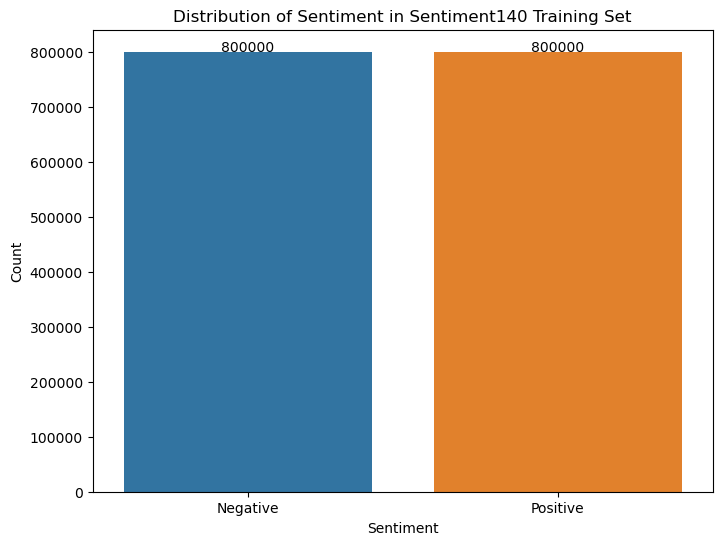

In [12]:
# SHOW SENTIMENT DISTRIBUTION IN TRAINING SET
distribution = df_train["target"].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=distribution.index, y=distribution.values)
plt.title("Distribution of Sentiment in Sentiment140 Training Set")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks([0, 1], ["Negative", "Positive"])

# ADD COUNTS ABOVE THE BARS
for i, v in enumerate(distribution.values):
    plt.text(i, v, str(v), ha="center")

plt.show()

### Word Cloud

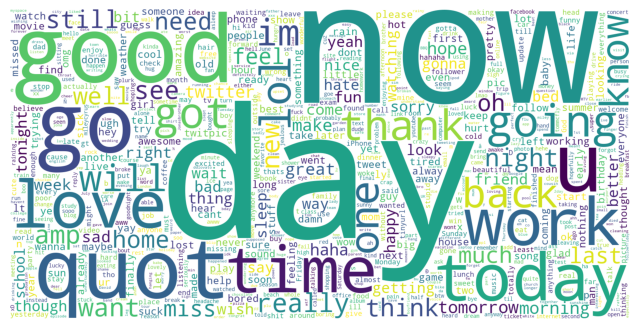

In [13]:
from wordcloud import WordCloud

wordcloud = WordCloud(
    width=1600,
    height=800,
    background_color="white",
    min_font_size=10,
    max_words=1000,
    collocations=False,
)
wordcloud.generate(" ".join(df_train["text"].tolist()))

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Preprocessing

Preprocessing is traditionally an important step for Natural Language Processing (NLP) tasks. It transforms text into a more digestible form so that machine learning algorithms can perform better.

Preprocessing steps include:

* Lower Casing: Each text is converted to lowercase.
* Replacing URLs: Links starting with "http" or "https" or "www" are replaced by "URL".
* Replacing Emojis: Replace emojis by using a pre-defined dictionary containing emojis along with their meaning. (eg: ":)" to "EMOJIsmile")
* Replacing Usernames: Replace @Usernames with word "USER". (eg: "@Kaggle" to "USER")
* Removing Non-Alphabets: Replacing characters except Digits and Alphabets with a space.
* Removing Consecutive letters: 3 or more consecutive letters are replaced by 2 letters. (eg: "Heyyyy" to "Heyy")
* Removing Short Words: Words with length less than 2 are removed.
* Removing Stopwords: Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. (eg: "the", "he", "have")
* Lemmatizing: Lemmatization is the process of converting a word to its base form. (e.g: "Great" to "Good")

In [14]:
# REMOVE UNNECESSARY COLUMNS
df_train = df_train[["text", "target"]]

Re-map sentiment labels to be `0 = negative` and `1 = positive` instead of of `4 = positive`.

In [15]:
df_train["target"] = df_train["target"].replace(4, 1)

In [16]:
# CHECK
df_train["target"]

0          0
1          0
2          0
3          0
4          0
          ..
1599995    1
1599996    1
1599997    1
1599998    1
1599999    1
Name: target, Length: 1600000, dtype: int64

### Stopwords

Stopwords like "the", "a", and "is" are so common that they are not useful for training the model.

The `nltk` library is used to remove stopwords.

In [17]:
# import re
# import nltk

# nltk.download("stopwords")
# from nltk.corpus import stopwords
# from nltk.stem.porter import PorterStemmer

# corpus = []
# for i in range(0, int(df_train.shape[0])):
#     text = re.sub("[^a-zA-z]", " ", df_train["text"][i])
#     text = text.lower()
#     text = text.split()
#     ps = PorterStemmer()
#     all_stopwords = stopwords.words("english")
#     all_stopwords.remove("not")
#     text = [ps.stem(word) for word in text if not word in set(all_stopwords)]
#     text = " ".join(text)
#     corpus.append(text)

### Stemming/Lemmatization

Stemming and lemmatization are used to reduce words to their root form.

We do this because many words have the same meaning but are written differently.

For example, "run", "runs", and "running" all have the same meaning.

This will reduce the number of unique words in the dataset.

In [18]:
# TODO: STEMMING/LEMMATIZATION

### Split the dataset into train and test sets

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_train["text"], df_train["target"], test_size=0.2, random_state=42
)

### TF-IDF Vectoriser

TF-IDF indicates what the importance of the word is in order to understand the document or dataset. Let us understand with an example. Suppose you have a dataset where students write an essay on the topic, My House. In this dataset, the word a appears many times; it’s a high frequency word compared to other words in the dataset. The dataset contains other words like home, house, rooms and so on that appear less often, so their frequency are lower and they carry more information compared to the word. This is the intuition behind TF-IDF.

TF-IDF Vectoriser converts a collection of raw documents to a matrix of TF-IDF features. The Vectoriser is usually trained on only the X_train dataset.

ngram_range is the range of number of words in a sequence. [e.g "very expensive" is a 2-gram that is considered as an extra feature separately from "very" and "expensive" when you have a n-gram range of (1,2)]

max_features specifies the number of features to consider. [Ordered by feature frequency across the corpus].

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectoriser = TfidfVectorizer(ngram_range=(1, 2), max_features=500000)
vectoriser.fit(X_train)

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

### Tranforming the dataset

Transforming the X_train and X_test dataset into matrix of TF-IDF Features by using the TF-IDF Vectoriser. This datasets will be used to train the model and test against it.

In [21]:
X_train = vectoriser.transform(X_train)
X_test = vectoriser.transform(X_test)

## Build & Evaluate Models

In [22]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)

In [23]:
import datetime
import joblib


def model_Evaluate(model):
    with wandb.init(
        project="project",
        config={"model": model},
        name=f"{datetime.datetime.now().strftime('%Y-%m-%d_%H:%M:%S')}_{model}",
    ) as run:
        # PREDICT VALUES FROM TEST DATASET
        y_pred = model.predict(X_test)

        # PRINT THE CLASSIFICATION REPORT
        print(classification_report(y_test, y_pred))

        # COMPUTE AND PLOT CONFUSION MATRIX
        cf_matrix = confusion_matrix(y_test, y_pred)
        categories = ["Negative", "Positive"]
        group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
        group_percentages = [
            "{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)
        ]
        labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_percentages)]
        labels = np.asarray(labels).reshape(2, 2)
        sns.heatmap(
            cf_matrix,
            annot=labels,
            cmap="Blues",
            fmt="",
            xticklabels=categories,
            yticklabels=categories,
        )
        plt.xlabel("Predicted values", fontdict={"size": 14}, labelpad=10)
        plt.ylabel("Actual values", fontdict={"size": 14}, labelpad=10)
        plt.title("Confusion Matrix", fontdict={"size": 18}, pad=20)

        # LOG TO W&B
        wandb.log(
            {
                "accuracy": accuracy_score(y_test, y_pred),
                "precision": precision_score(
                    y_test, y_pred, average="weighted", zero_division=1
                ),
                "recall": recall_score(y_test, y_pred, average="weighted"),
                "f1": f1_score(y_test, y_pred, average="weighted"),
                "roc_auc": roc_auc_score(y_test, y_pred),
                "confusion_matrix": wandb.Image(plt),   
            }
        )

        # LOG MODEL
        artifact = wandb.Artifact("model", type="model")
        joblib.dump(model, "model.pkl")
        artifact.add_file("model.pkl")
        run.log_artifact(artifact)
        os.remove("model.pkl")

### Bernoulli Naive Bayes

              precision    recall  f1-score   support

           0       0.80      0.79      0.80    159494
           1       0.80      0.81      0.80    160506

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



accuracy,▁
f1,▁
precision,▁
recall,▁
roc_auc,▁
accuracy,0.79946
f1,0.79945
precision,0.79952
recall,0.79946
roc_auc,0.79944


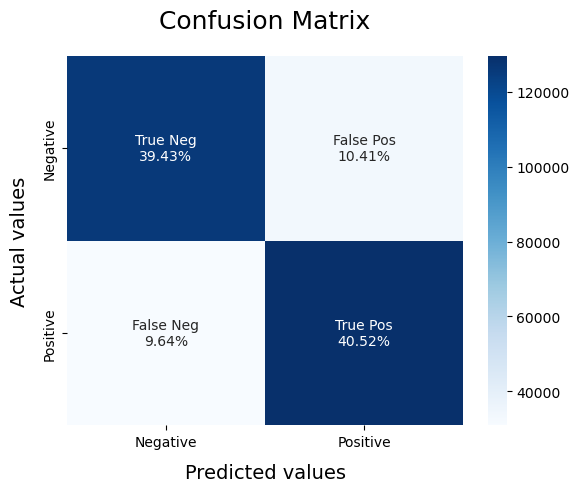

In [24]:
from sklearn.naive_bayes import BernoulliNB

BNBmodel = BernoulliNB(alpha=2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

### Linear Support Vector Classification

              precision    recall  f1-score   support

           0       0.82      0.81      0.81    159494
           1       0.81      0.82      0.82    160506

    accuracy                           0.81    320000
   macro avg       0.81      0.81      0.81    320000
weighted avg       0.81      0.81      0.81    320000



accuracy,▁
f1,▁
precision,▁
recall,▁
roc_auc,▁
accuracy,0.81479
f1,0.81478
precision,0.81484
recall,0.81479
roc_auc,0.81477


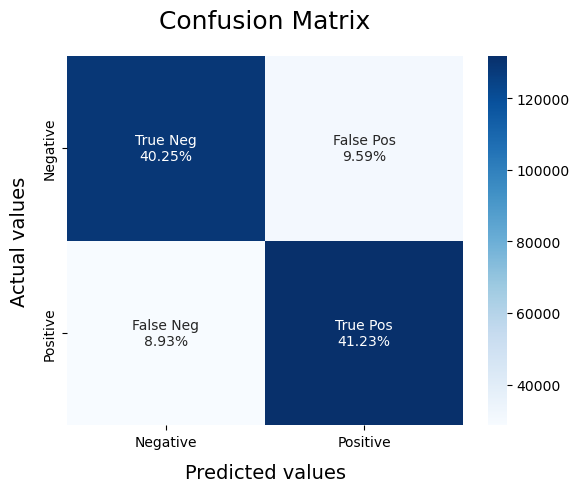

In [25]:
from sklearn.svm import LinearSVC

SVCmodel = LinearSVC(dual=False)
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

### Logistic Regression

              precision    recall  f1-score   support

           0       0.83      0.82      0.82    159494
           1       0.82      0.83      0.83    160506

    accuracy                           0.83    320000
   macro avg       0.83      0.83      0.83    320000
weighted avg       0.83      0.83      0.83    320000



accuracy,▁
f1,▁
precision,▁
recall,▁
roc_auc,▁
accuracy,0.82575
f1,0.82574
precision,0.82583
recall,0.82575
roc_auc,0.82573


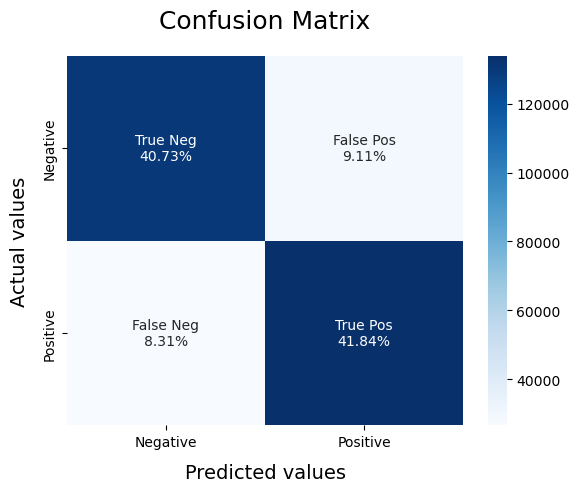

In [26]:
from sklearn.linear_model import LogisticRegression

LRmodel = LogisticRegression(C=2, max_iter=1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)